# Final Branch Coverage (Single Parameter) 

This is a Notebook used to determine if adaptive parameter control have any effect on the final branch coverage.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


<Figure size 400x300 with 0 Axes>

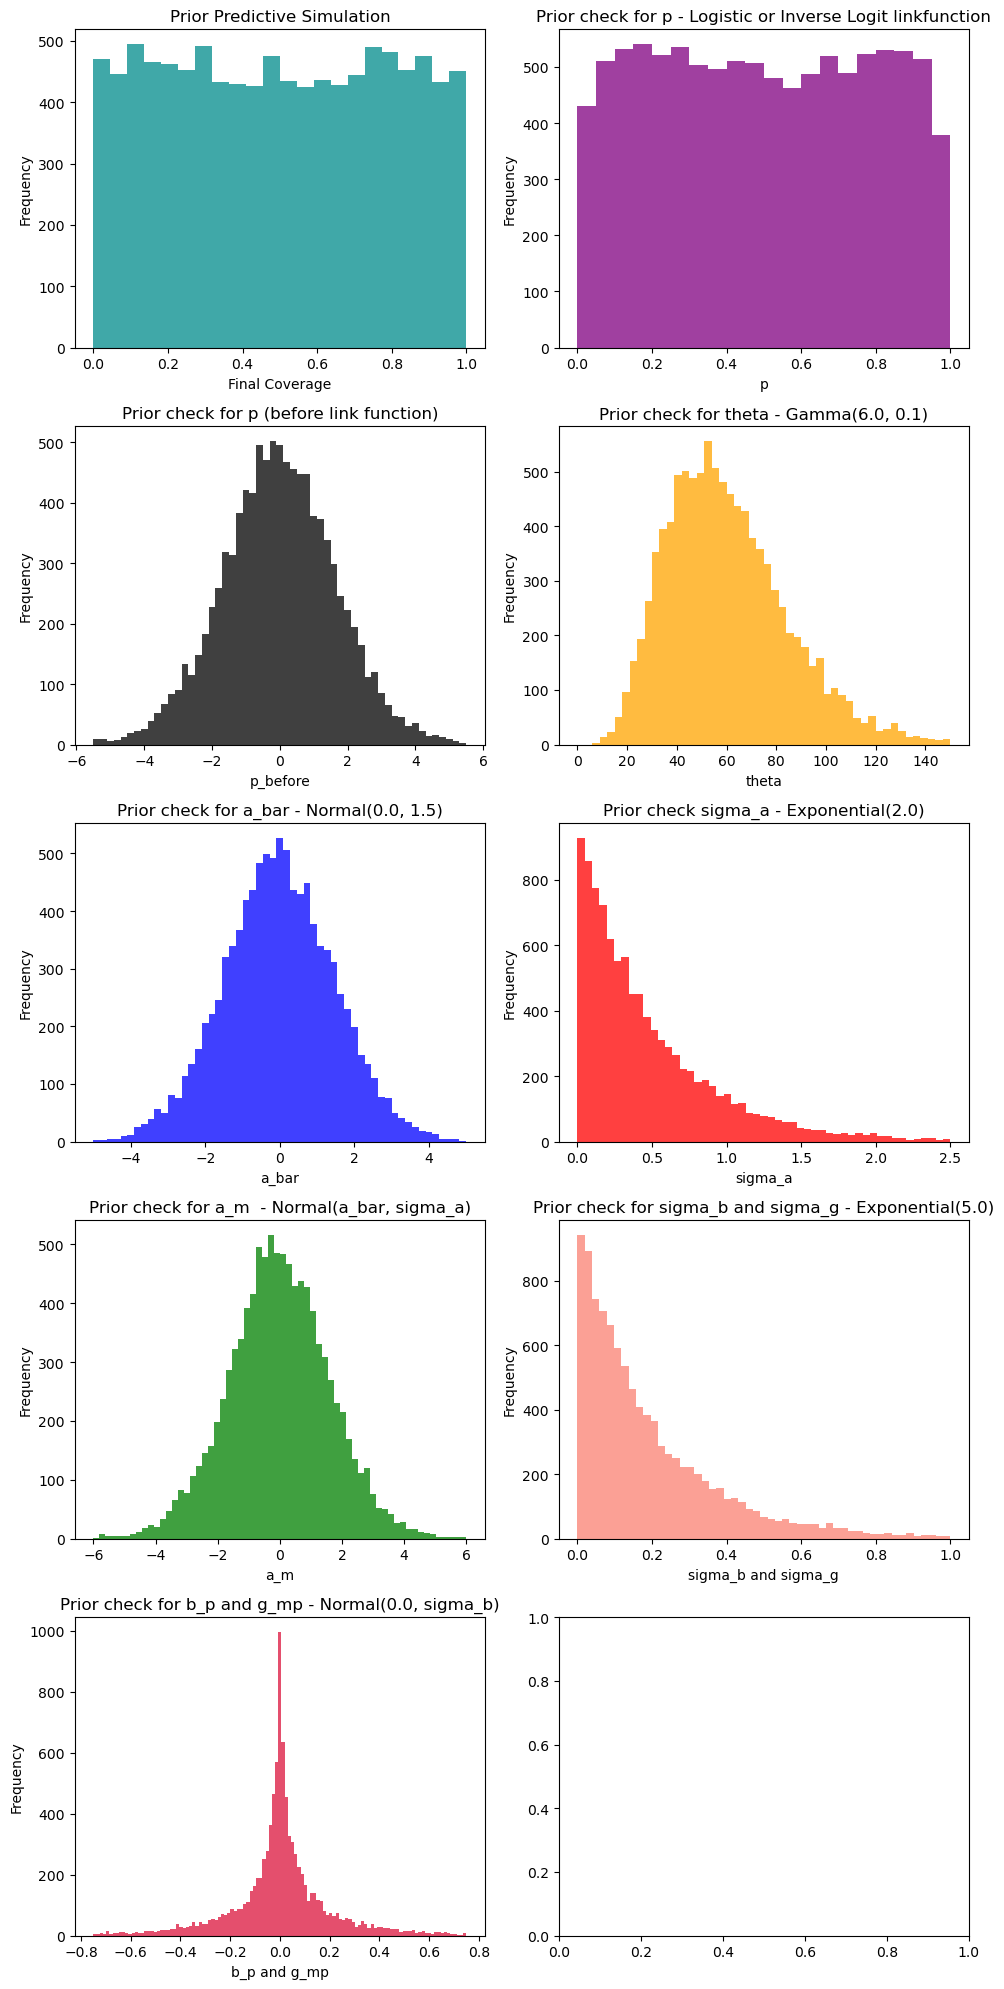

In [13]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard deviation for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)
        

        # Link function (logit), from unbounded to (0,1) probability
        pm.Deterministic('p_before', (a_m + b_p + g_mp))        
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=6, beta= 0.1)

        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Use alpha and beta as parameters for a Beta distribution to sample observations
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Final Coverage',
                                        'darkcyan', bin_range=(0, 1.0))

    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior check for p - Logistic or Inverse Logit linkfunction', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior check for p (before link function)', 'p_before', 'black', bin_range=(-5.5, 5.5)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior check for theta - Gamma(6.0, 0.1)', 'theta', 'orange', bin_range= (0,150)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(0.0, 1.5)', 'a_bar', 'blue', bin_range=(-5,5)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a - Exponential(2.0)', 'sigma_a', 'red', bin_range=(0,2.5)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m  - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(-6, 6)),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior check for sigma_b and sigma_g - Exponential(5.0)', 'sigma_b and sigma_g', 'salmon', bin_range=(0, 1)),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p and g_mp - Normal(0.0, sigma_b)', 'b_p and g_mp', 'crimson', bin_range=(-0.75, 0.75)),
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20), save_img=False, prefix_name="final_coverage_single", output_folder="prior_checks/final_coverage_single")


perform_prior_check(2, 5, 5, 0, 1.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(perform_prior_check, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, )

# Model specification

### Data Preperation

In [6]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies


data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'Coverage')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 5.0)
    sigma_g = pm.Exponential('sigma_g', 5.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), from unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beta distribution likelihood with parameters alpha and beta
    theta = pm.Gamma('theta', alpha=6, beta= 0.1) # Dispersion/spread parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "final_coverage_model_single_parameter.nc")

# Data analysis


### Generate summary object (without transformations)

In [1]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500) 

# Example usage
trace = az.from_netcdf("../single_parameter/final_coverage_model_single_parameter.nc")
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)

### Replace numeric identifiers with descriptive identifiers

In [2]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)


Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


mean     sd  hdi_5.5%  \
a_m[packages]                                    -2.907  0.034    -2.961   
a_m[cmd]                                         -2.492  0.030    -2.541   
a_m[dict_unpacking]                              -1.817  0.025    -1.855   
a_m[signals]                                     -1.417  0.022    -1.453   
a_m[return_from_generator]                       -1.222  0.022    -1.258   
a_m[python]                                      -1.216  0.022    -1.251   
a_m[py_base]                                     -0.951  0.021    -0.983   
a_m[positional_validation]                       -0.911  0.021    -0.944   
a_m[journaling]                                  -0.737  0.020    -0.770   
g_mp[return_from_generator x Pop]                -0.226  0.058    -0.315   
a_m[lazy_import]                                 -0.120  0.019    -0.152   
g_mp[return_from_generator x ChromLen]           -0.088  0.041    -0.153   
g_mp[return_from_generator x TestDeleteProb]     -0.078  0.040    -0.141   
g_mp[return_from_generator x StatemInsertProb]   -0.061  0.039    -0.124   
a_m[yield_from]                                  -0.043  0.020    -0.074   
g_mp[positional_validation x TestInsertProb]     -0.037  0.036    -0.094   
g_mp[yield_from x ChangeParamProb]               -0.033  0.036    -0.089   
g_mp[py_base x RandPert]                         -0.028  0.036    -0.085   
g_mp[journaling x Crossover]                     -0.024  0.036    -0.081   
g_mp[journaling x TourSize]                      -0.022  0.036    -0.079   
g_mp[s_helpers x ChangeParamProb]                -0.021  0.036    -0.079   
g_mp[config x Pop]                               -0.021  0.037    -0.080   
g_mp[yield_from x RandPert]                      -0.020  0.035    -0.077   
g_mp[yield_from x TestDeleteProb]                -0.020  0.035    -0.075   
g_mp[positional_validation x TestChangeProb]     -0.018  0.036    -0.077   
g_mp[positional_validation x Crossover]          -0.018  0.036    -0.073   
g_mp[yield_from x TourSize]                      -0.018  0.035    -0.071   
g_mp[positional_validation x TourSize]           -0.018  0.036    -0.073   
b_p[Pop]                                         -0.017  0.015    -0.039   
g_mp[positional_validation x ChromLen]           -0.016  0.036    -0.073   
g_mp[positional_validation x TestDeleteProb]     -0.016  0.036    -0.073   
g_mp[h_base x Elite]                             -0.016  0.036    -0.075   
g_mp[py_base x StatemInsertProb]                 -0.016  0.036    -0.073   
g_mp[yield_from x Pop]                           -0.016  0.035    -0.072   
g_mp[s_helpers x TourSize]                       -0.015  0.036    -0.074   
g_mp[py_base x Pop]                              -0.015  0.037    -0.074   
g_mp[h_base x ChromLen]                          -0.013  0.036    -0.069   
g_mp[h_base x TestDeleteProb]                    -0.013  0.037    -0.071   
g_mp[packages x TestInsertionProb]               -0.012  0.041    -0.077   
g_mp[dict_unpacking x RandPert]                  -0.012  0.038    -0.071   
g_mp[py_base x ChromLen]                         -0.012  0.036    -0.068   
g_mp[s_helpers x TestDeleteProb]                 -0.012  0.037    -0.073   
g_mp[packages x ChangeParamProb]                 -0.011  0.040    -0.073   
g_mp[dict_unpacking x TourSize]                  -0.011  0.038    -0.069   
g_mp[packages x Elite]                           -0.011  0.041    -0.076   
g_mp[return_from_generator x TestChangeProb]     -0.011  0.036    -0.071   
g_mp[packages x TestChangeProb]                  -0.010  0.040    -0.073   
g_mp[s_helpers x Pop]                            -0.010  0.037    -0.067   
g_mp[packages x Crossover]                       -0.010  0.040    -0.072   
g_mp[h_base x Pop]                               -0.010  0.037    -0.069   
g_mp[config x Elite]                             -0.010  0.037    -0.067   
g_mp[dict_unpacking x TestDeleteProb]            -0.009  0.038    -0.070   
g_mp[packages x ChromLe

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

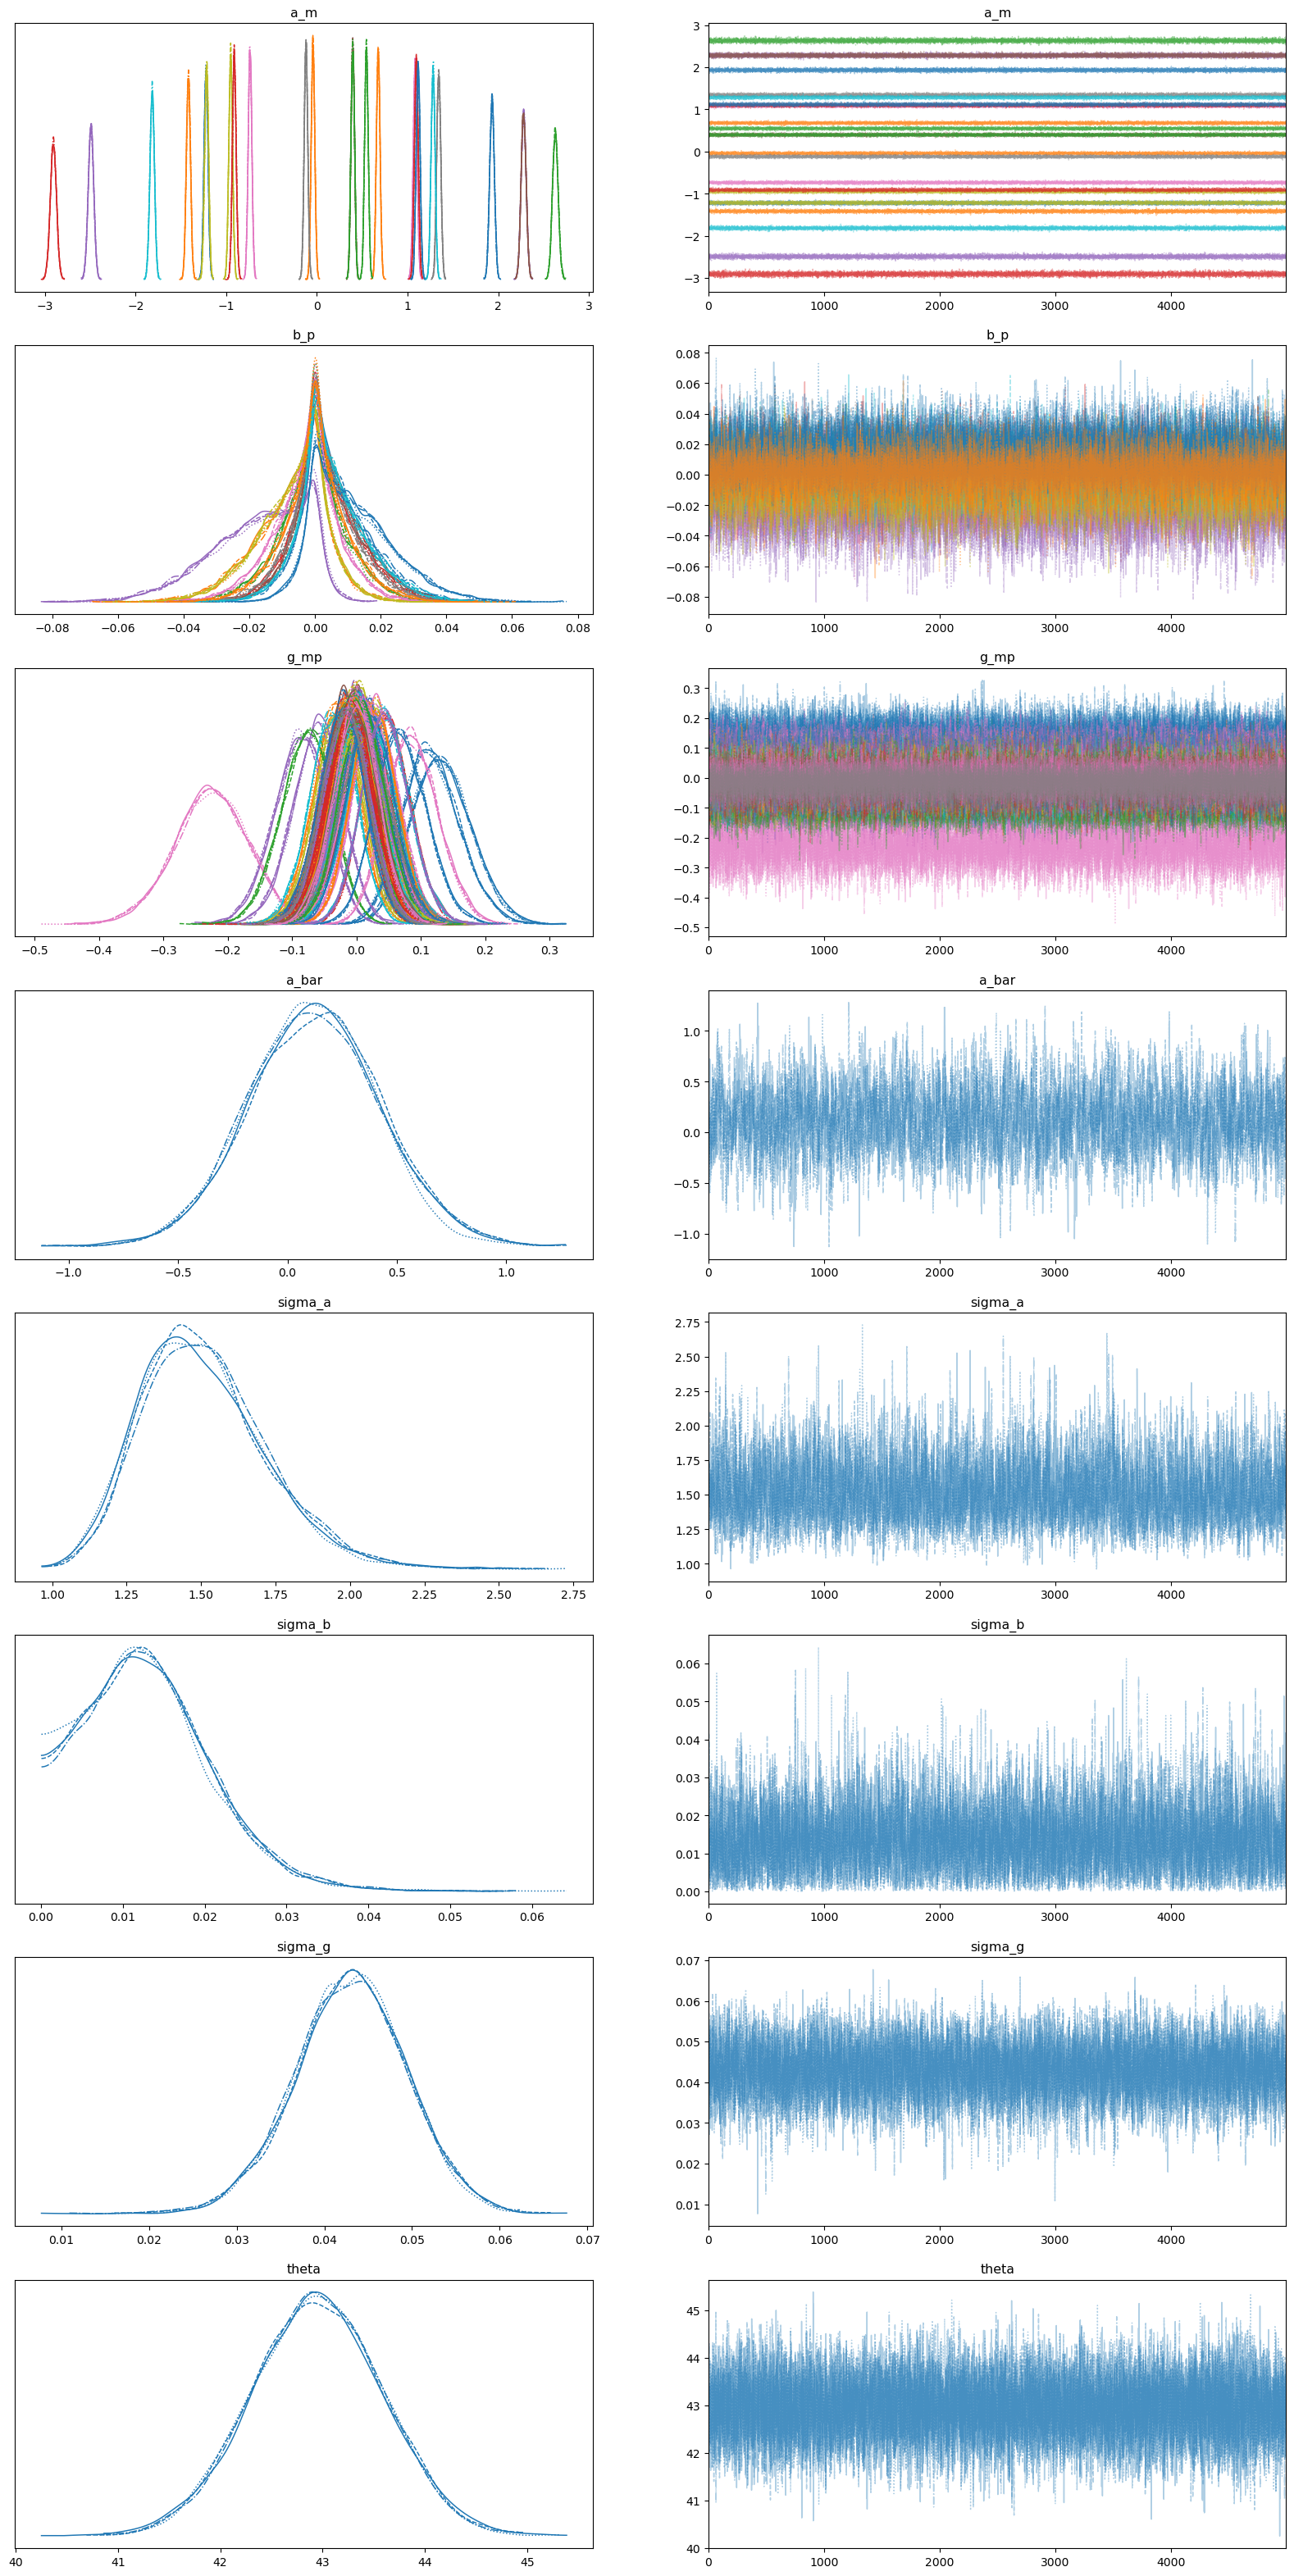

In [3]:
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=variable_list, figsize=(20, 40))

### Transformed effects

In [5]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("../single_parameter/final_coverage_model_single_parameter.nc")
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {
    'a_m': logit_to_probability,
    'b_p': log_to_exp,
    'g_mp':log_to_exp,
    'a_bar': logit_to_probability
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)

In [6]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


mean     sd  hdi_5.5%  \
sigma_b                                           0.013  0.008     0.000   
sigma_g                                           0.043  0.006     0.033   
a_m[packages]                                     0.052  0.002     0.049   
a_m[cmd]                                          0.076  0.002     0.073   
a_m[dict_unpacking]                               0.140  0.003     0.135   
a_m[signals]                                      0.195  0.004     0.190   
a_m[return_from_generator]                        0.228  0.004     0.221   
a_m[python]                                       0.229  0.004     0.222   
a_m[py_base]                                      0.279  0.004     0.272   
a_m[positional_validation]                        0.287  0.004     0.280   
a_m[journaling]                                   0.324  0.004     0.316   
a_m[lazy_import]                                  0.470  0.005     0.462   
a_m[yield_from]                                   0.489  0.005     0.482   
a_bar                                             0.530  0.074     0.412   
a_m[pgzero_frontend]                              0.598  0.005     0.590   
a_m[headers]                                      0.598  0.005     0.590   
a_m[py_helpers]                                   0.633  0.005     0.626   
a_m[decorators]                                   0.663  0.004     0.656   
a_m[h_base]                                       0.747  0.004     0.741   
a_m[immutable_list]                               0.750  0.004     0.744   
a_m[s_helpers]                                    0.753  0.004     0.747   
a_m[config]                                       0.783  0.004     0.777   
a_m[da]                                           0.793  0.004     0.787   
g_mp[return_from_generator x Pop]                 0.799  0.046     0.729   
a_m[timer]                                        0.873  0.003     0.869   
a_m[validation]                                   0.907  0.002     0.904   
a_m[maybe]                                        0.907  0.002     0.904   
g_mp[return_from_generator x ChromLen]            0.916  0.037     0.857   
g_mp[return_from_generator x TestDeleteProb]      0.926  0.037     0.869   
a_m[namedtupleutils]                              0.933  0.002     0.930   
g_mp[return_from_generator x StatemInsertProb]    0.942  0.036     0.883   
g_mp[positional_validation x TestInsertProb]      0.964  0.035     0.907   
g_mp[yield_from x ChangeParamProb]                0.968  0.035     0.915   
g_mp[py_base x RandPert]                          0.973  0.035     0.917   
g_mp[journaling x Crossover]                      0.977  0.035     0.922   
g_mp[journaling x TourSize]                       0.978  0.035     0.924   
g_mp[s_helpers x ChangeParamProb]                 0.980  0.036     0.924   
g_mp[config x Pop]                                0.980  0.036     0.923   
g_mp[yield_from x TestDeleteProb]                 0.981  0.034     0.926   
g_mp[yield_from x RandPert]                       0.981  0.034     0.926   
g_mp[positional_validation x TestChangeProb]      0.982  0.036     0.924   
g_mp[positional_validation x Crossover]           0.983  0.035     0.930   
g_mp[positional_validation x TourSize]            0.983  0.035     0.925   
g_mp[yield_from x TourSize]                       0.983  0.034     0.928   
b_p[Pop]                                          0.984  0.014     0.962   
g_mp[positional_validation x TestDeleteProb]      0.985  0.036     0.927   
g_mp[positional_validation x ChromLen]            0.985  0.035     0.929   
g_mp[py_base x StatemInsertProb]                  0.985  0.036     0.927   
g_mp[py_base x Pop]                               0.985  0.036     0.929   
g_mp[yield_from x Pop]                            0.985  0.035     0.930   
g_mp[h_base x Elite]                              0.985  0.036     0.927   
g_mp[s_helpers x TourSize]                        0.986  0.036     0.928   
g_mp[h_base x TestDelet

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

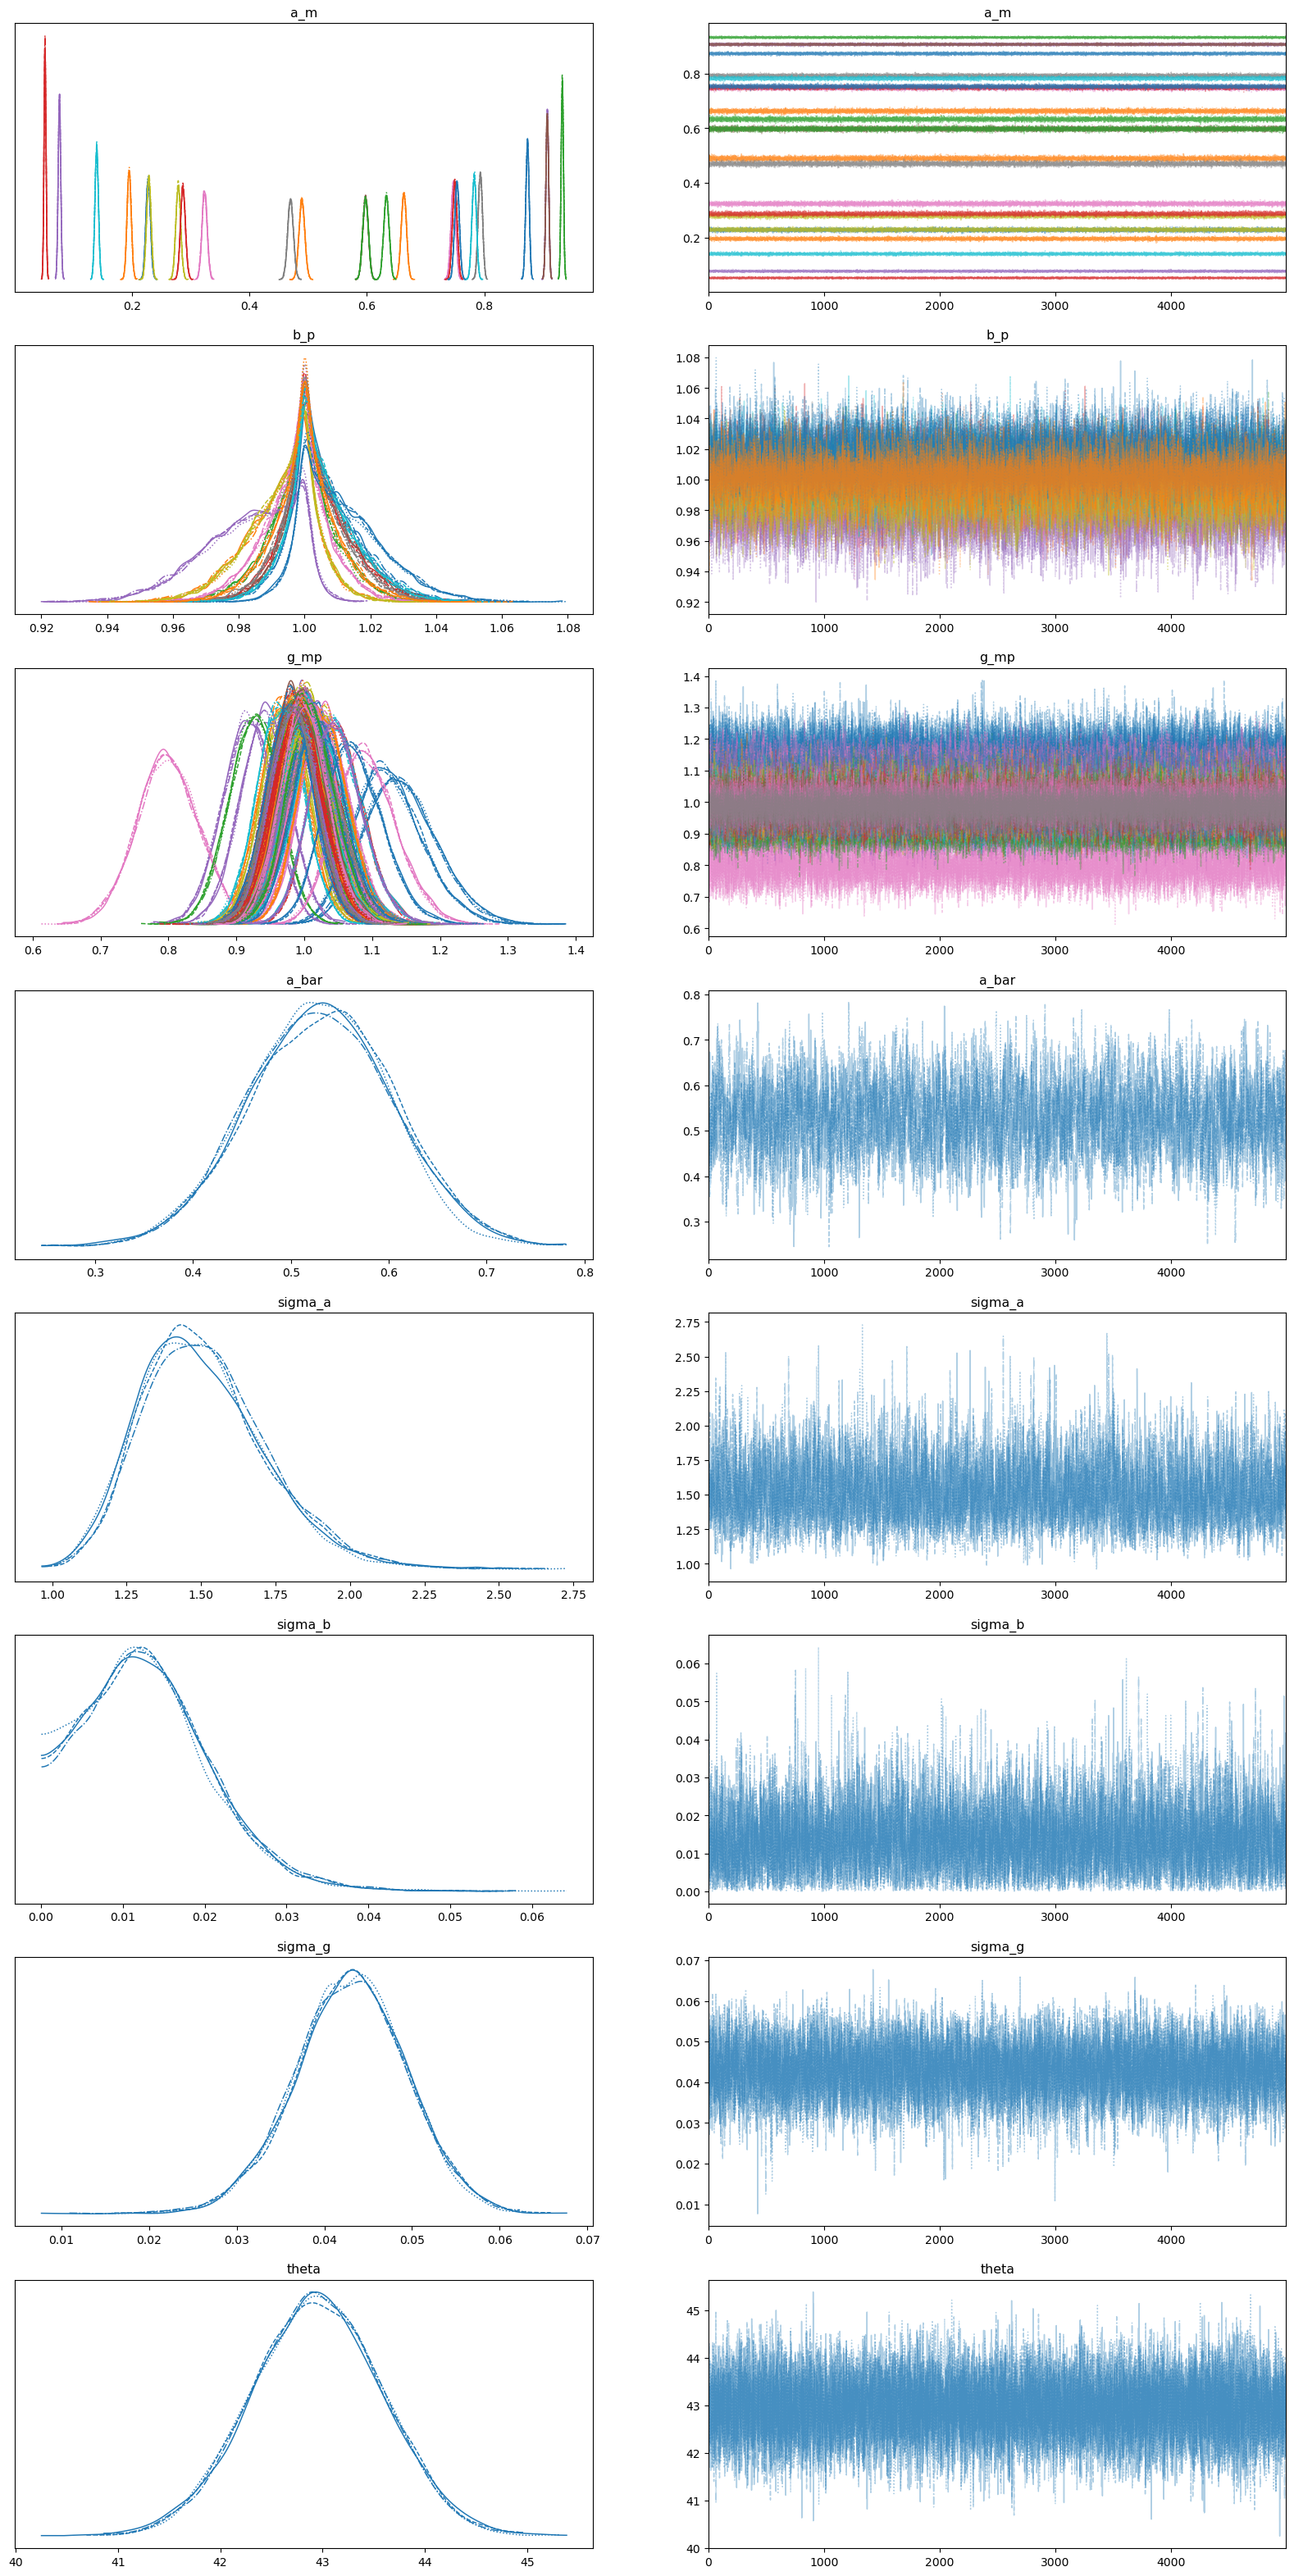

In [7]:
az.plot_trace(idata_transformed, var_names=variable_list, figsize=(20, 40))